In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv("Startups.csv")
print(data.head())

   R&D Spend  Administration  Marketing Spend       State     Profit
0  165349.20       136897.80        471784.10    New York  192261.83
1  162597.70       151377.59        443898.53  California  191792.06
2  153441.51       101145.55        407934.54     Florida  191050.39
3  144372.41       118671.85        383199.62    New York  182901.99
4  142107.34        91391.77        366168.42     Florida  166187.94


In [3]:
# Check the shape of the data
print(data.shape)


(50, 5)


In [4]:
# Data Preprocessing
print(data.dtypes)
print(data.isna().sum()) # Check for null values


R&D Spend          float64
Administration     float64
Marketing Spend    float64
State               object
Profit             float64
dtype: object
R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64


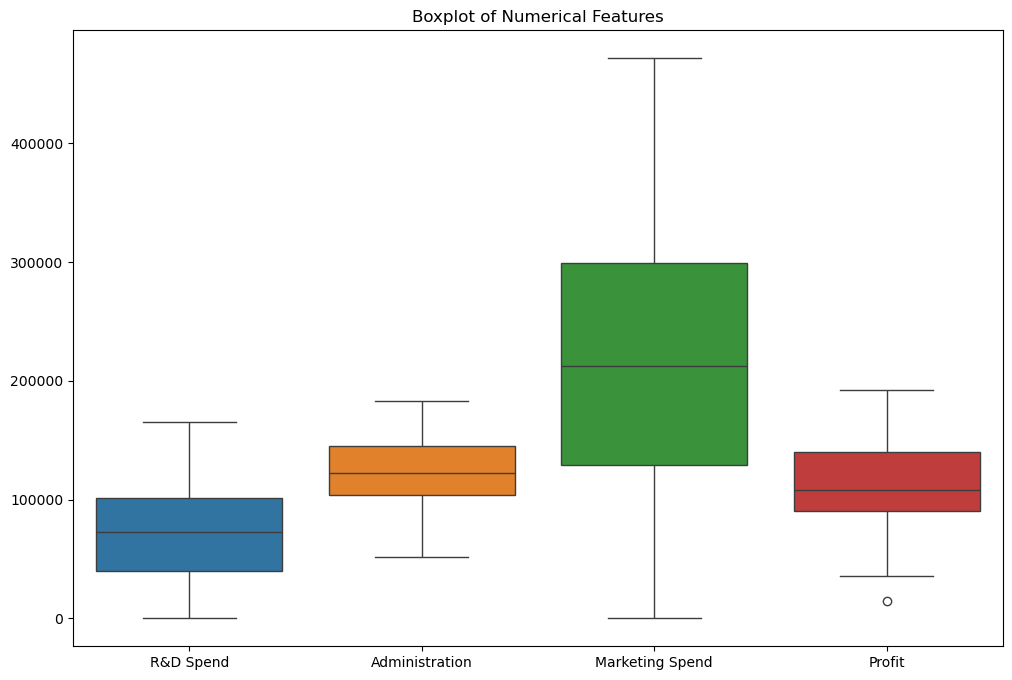

In [5]:

# Check for outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[["R&D Spend", "Administration", "Marketing Spend", "Profit"]])
plt.title("Boxplot of Numerical Features")
plt.show()

In [6]:
# Descriptive statistics
print(data.describe())

           R&D Spend  Administration  Marketing Spend         Profit
count      50.000000       50.000000        50.000000      50.000000
mean    73721.615600   121344.639600    211025.097800  112012.639200
std     45902.256482    28017.802755    122290.310726   40306.180338
min         0.000000    51283.140000         0.000000   14681.400000
25%     39936.370000   103730.875000    129300.132500   90138.902500
50%     73051.080000   122699.795000    212716.240000  107978.190000
75%    101602.800000   144842.180000    299469.085000  139765.977500
max    165349.200000   182645.560000    471784.100000  192261.830000


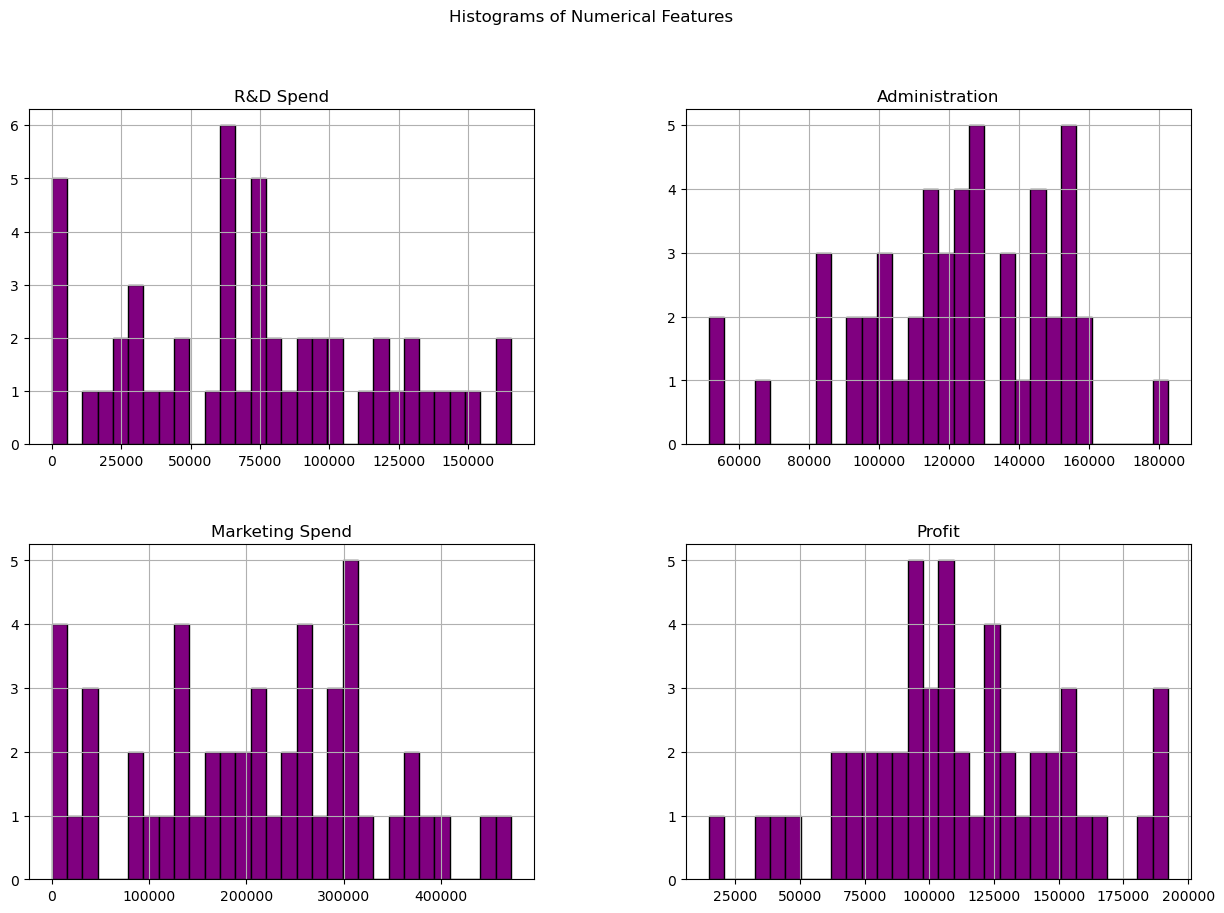

In [7]:
# Univariate Analysis
data.hist(figsize=(15, 10), bins=30, color='purple', edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.show()

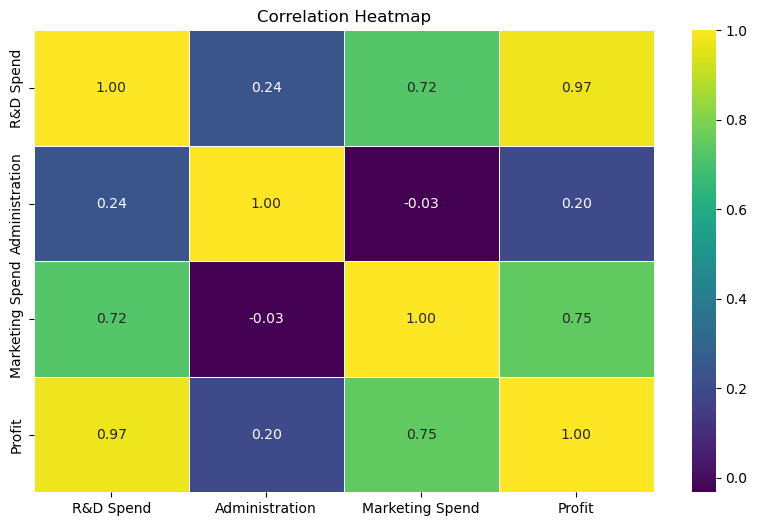

In [8]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data[["R&D Spend", "Administration", "Marketing Spend", "Profit"]].corr(), annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [9]:
# Drop "State" column as it is not needed
df = data.drop(columns=["State"])

In [10]:
# Define numerical features and target
numerical_cols = ["R&D Spend", "Administration", "Marketing Spend"]  # Numerical
target_col = "Profit"

In [11]:
# Define features (X) and target (y)
X = df.drop(columns=[target_col])
y = df[target_col]

In [12]:
# Split data into Train & Test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Scale numerical features (Avoid modifying X_train/X_test directly)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [14]:
# Build Multilinear Regression Model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [15]:
# Predict on test data
y_pred = model.predict(X_test_scaled)

In [16]:
# Model coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

Intercept: 115651.72050000001
Coefficients: [38014.73625775 -1841.47578233  3543.38628169]


In [17]:
# Check for Multicollinearity (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factor (VIF):\n", vif_data)



Variance Inflation Factor (VIF):
            Feature       VIF
0        R&D Spend  8.384571
1   Administration  4.026406
2  Marketing Spend  7.593984


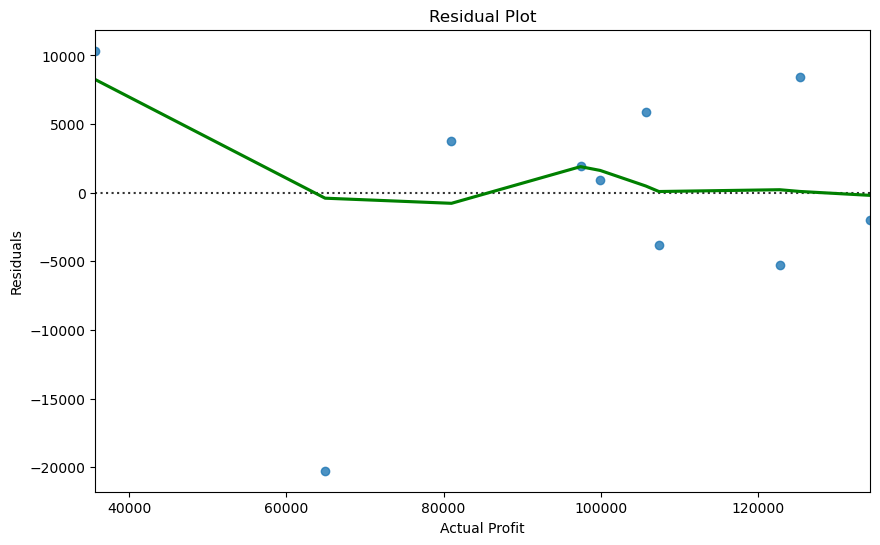

In [18]:
# Diagnostic Plots
plt.figure(figsize=(10, 6))
sns.residplot(x=y_test, y=y_pred, lowess=True, line_kws={"color": "green"})
plt.xlabel("Actual Profit")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [19]:

# Evaluate Model Performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared Score: {r2:.4f}")


Root Mean Squared Error (RMSE): 8995.91
R-Squared Score: 0.9001


In [20]:
# Model Tuning (Regularization)
# Ridge Regression (L2 Regularization)
ridge = Ridge(alpha=1)
ridge.fit(X_train_scaled, y_train)
y_ridge_pred = ridge.predict(X_test_scaled)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_ridge_pred))


In [21]:
# Lasso Regression (L1 Regularization)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_lasso_pred = lasso.predict(X_test_scaled)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_lasso_pred))


In [22]:
# Compare Models
print("\nModel Comparison:")
print(f"Linear Regression RMSE: {rmse:.2f}")
print(f"Ridge Regression RMSE: {ridge_rmse:.2f}")
print(f"Lasso Regression RMSE: {lasso_rmse:.2f}")



Model Comparison:
Linear Regression RMSE: 8995.91
Ridge Regression RMSE: 9178.35
Lasso Regression RMSE: 8995.80


In [24]:
# Ridge Tuning
from sklearn.model_selection import GridSearchCV
ridge_params = {"alpha": np.logspace(-3, 3, 50)}
ridge_cv = GridSearchCV(Ridge(), ridge_params, scoring="neg_mean_squared_error", cv=5)
ridge_cv.fit(X_train_scaled, y_train)
best_ridge = ridge_cv.best_estimator_
print(f"Best Ridge Alpha: {ridge_cv.best_params_['alpha']}")

Best Ridge Alpha: 0.001


In [25]:
# Lasso Tuning
lasso_params = {"alpha": np.logspace(-3, 3, 50)}
lasso_cv = GridSearchCV(Lasso(), lasso_params, scoring="neg_mean_squared_error", cv=5)
lasso_cv.fit(X_train_scaled, y_train)
best_lasso = lasso_cv.best_estimator_
print(f"Best Lasso Alpha: {lasso_cv.best_params_['alpha']}")

print("Lasso Coefficients:", lasso.coef_)


Best Lasso Alpha: 1.151395399326447
Lasso Coefficients: [38015.0880309  -1841.49019422  3543.02226589]


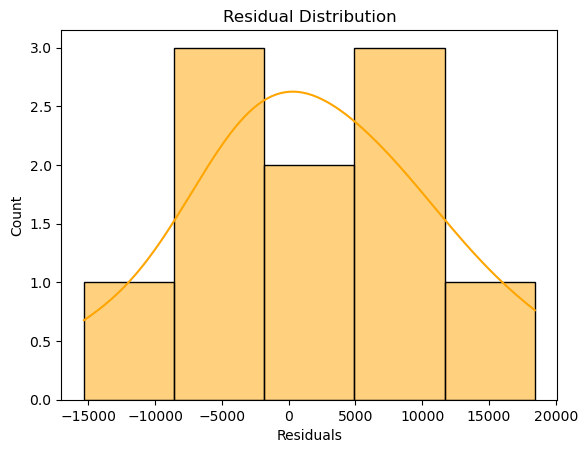

In [26]:
# Residual Distribution Plot
sns.histplot(y_test - y_pred, kde=True, color='orange')
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.show()

C:\Users\viren\AppData\Local\Temp\ipykernel_1048\1760565700.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


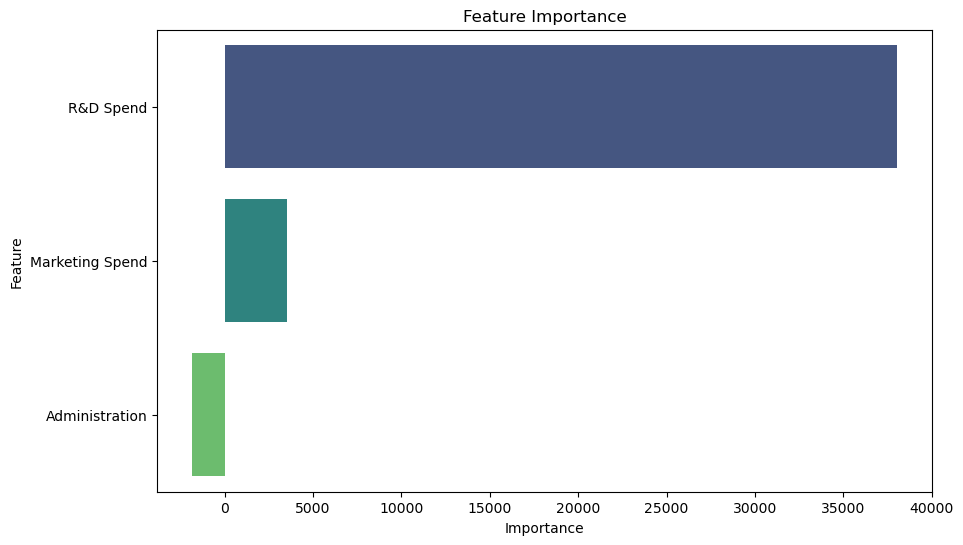


Feature Importance:
            Feature    Importance
0        R&D Spend  38014.736258
2  Marketing Spend   3543.386282
1   Administration  -1841.475782


In [27]:

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': numerical_cols,
    'Importance': model.coef_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

print("\nFeature Importance:\n", feature_importance)